In [45]:
import os

import astropy.units as u
import numpy as np
import requests
from astropy.cosmology import Planck18 as cosmo
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp

In [46]:
def download_file(url, filename):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        return filename
    except Exception as e:
        print(f"Error downloading file: {e}")
        return None

## 1. Read distribution sample.

In [47]:
filename = "O4_result/baseline5_widesigmachi2_mass_NotchFilterBinnedPairingMassDistribution_redshift_powerlaw_mag_iid_spin_magnitude_gaussian_tilt_iid_spin_orientation_result_events_baseline5_all.h5"

In [48]:
table = Table.read(filename)
table[:2]

mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2
float64,float64,float64,float64,float64,float64,float64,float64
1.4003127807104705,0.934954537546301,0.25226035333012586,0.17081800015796333,-0.07445077428355917,0.9653381954834288,1.4144591708724004,1.3092287883093328
1.6007200708910987,0.9777425764328481,0.14350300511641967,0.05476595988100175,0.8604462381564546,0.7046866211743108,1.3044228619425053,1.5650921662608341


## 2. Convert GWTC-4's distribution to suitable format for bayestar-inject

In [49]:
z = table["redshift"]
distance = cosmo.luminosity_distance(z).to_value(u.Mpc)

gwtc4_samples = Table(
    {
        "mass1": table["mass_1"],
        "mass2": table["mass_2"],
        "spin1z": table["a_1"] * table["cos_tilt_1"],
        "spin2z": table["a_2"] * table["cos_tilt_2"],
        "distance": distance,
    }
)

## 3. Number of events in each sub-population

In [50]:
ns_max_mass = 3
source_mass1 = gwtc4_samples["mass1"]
source_mass2 = gwtc4_samples["mass2"]

# classify systems

BNS = np.sum((source_mass1 < ns_max_mass) & (source_mass2 < ns_max_mass))
NSBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 < ns_max_mass))
BBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 >= ns_max_mass))

In [51]:
# print results
print("CBC classification results:")
print(f"  BNS  : {BNS}")
print(f"  NSBH : {NSBH}")
print(f"  BBH  : {BBH}")

CBC classification results:
  BNS  : 740077
  NSBH : 160672
  BBH  : 99251


## GWTC-3 distribustion

In [52]:
# gwtc3_samples = Table.read("./data/farah.h5")

# gwtc3_samples[:2]

file_url = "https://dcc.ligo.org/LIGO-T2100512/public/O1O2O3all_mass_h_iid_mag_iid_tilt_powerlaw_redshift_maxP_events_all.h5"
file_name = os.path.join("data", file_url.split("/")[-1])
input_file = download_file(file_url, file_name)

In [53]:
gwtc3_table = Table.read(input_file)

z = gwtc3_table["redshift"]
distance = cosmo.luminosity_distance(z).to_value(u.Mpc)

gwtc3_samples = Table(
    {
        "mass1": gwtc3_table["mass_1"],
        "mass2": gwtc3_table["mass_2"],
        "spin1z": gwtc3_table["a_1"] * gwtc3_table["cos_tilt_1"],
        "spin2z": gwtc3_table["a_2"] * gwtc3_table["cos_tilt_2"],
        "distance": distance,
    }
)

In [54]:
gwtc3_table[:2]

mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2
float64,float64,float64,float64,float64,float64,float64,float64
1.6334784673051967,0.8454894156909176,0.017967576173918476,0.16004897675006174,0.031869301994897015,-0.07514292551559631,1.4449414896699722,1.3810887548655666
2.4116235511053596,0.8454587847570831,0.3488277731583293,0.15886112907941302,0.27419198147524115,0.810559577143116,0.4689085689630565,2.038928316809099


In [55]:
ns_max_mass = 3
source_mass1 = gwtc3_samples["mass1"]
source_mass2 = gwtc3_samples["mass2"]

# classify systems

BNS = np.sum((source_mass1 < ns_max_mass) & (source_mass2 < ns_max_mass))
NSBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 < ns_max_mass))
BBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 >= ns_max_mass))

# print results
print("CBC classification results:")
print(f"  BNS  : {BNS}")
print(f"  NSBH : {NSBH}")
print(f"  BBH  : {BBH}")

CBC classification results:
  BNS  : 892762
  NSBH : 35962
  BBH  : 71276


# KS Test

In [56]:
gwtc3_samples["log10_distance"] = np.log10(gwtc3_samples["distance"])
gwtc4_samples["log10_distance"] = np.log10(gwtc4_samples["distance"])

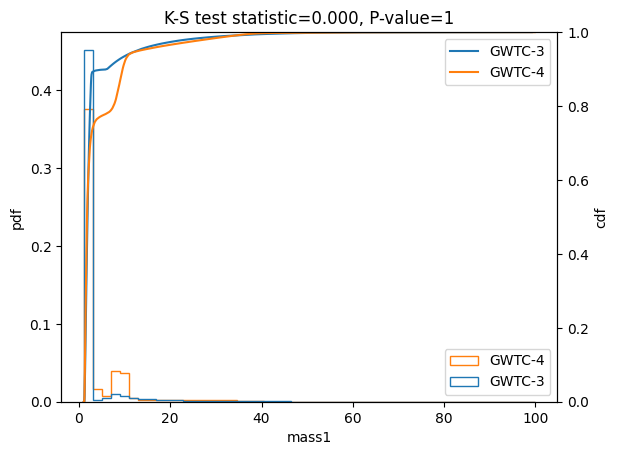

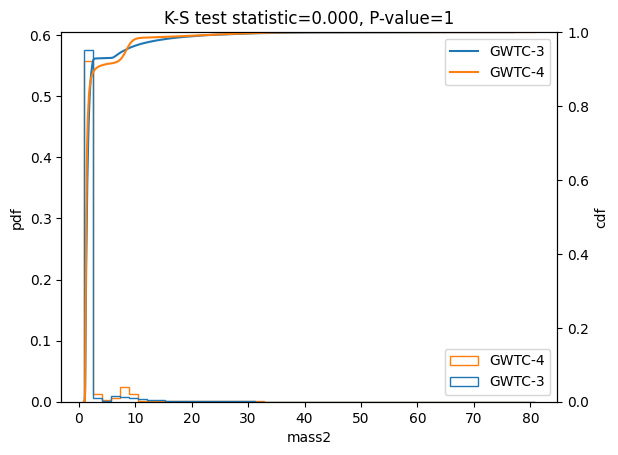

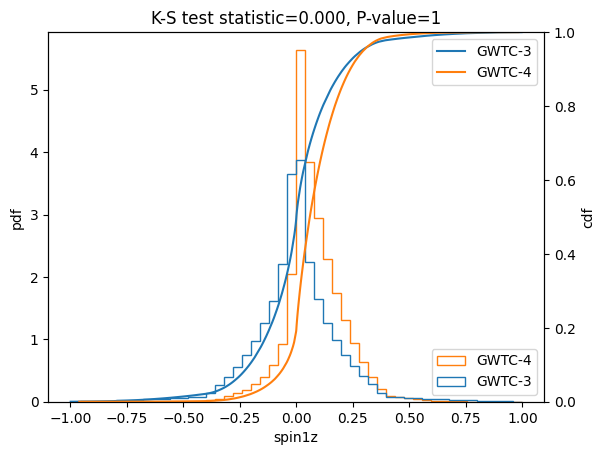

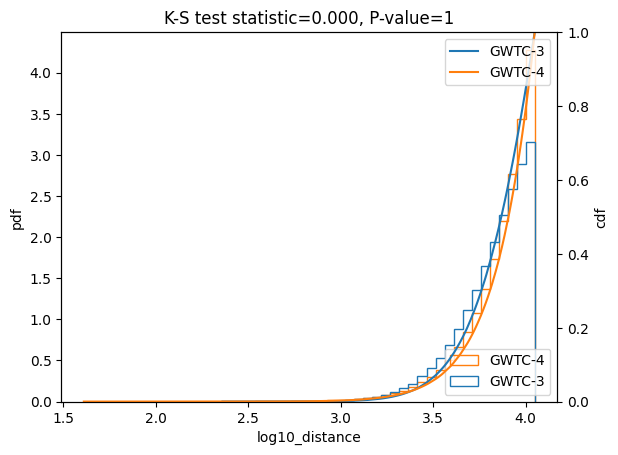

In [57]:
for col in ["mass1", "mass2", "spin1z", "spin2z", "log10_distance"]:
    fig, ax = plt.subplots()
    ax.hist(
        [gwtc3_samples[col], gwtc4_samples[col]],
        label=["GWTC-3", "GWTC-4"],
        histtype="step",
        density=1,
        bins=50,
    )
    ax.set_ylim(0, None)
    ax.set_ylabel("pdf")
    ax2 = ax.twinx()
    ax2.set_ylabel("cdf")
    ax2.set_ylim(0, 1)
    ax2.plot(
        np.sort(gwtc3_samples[col]),
        np.linspace(0, 1, len(gwtc3_samples)),
        label="GWTC-3",
    )
    ax2.plot(
        np.sort(gwtc4_samples[col]),
        np.linspace(0, 1, len(gwtc4_samples)),
        label="GWTC-4",
    )
    ax.legend(loc="lower right")
    ax2.legend(loc="upper right")
    stat, pvalue = ks_2samp(gwtc4_samples[col], gwtc4_samples[col])
    ax.set_xlabel(col)
    ax.set_title(f"K-S test statistic={stat:0.3f}, P-value={pvalue:0.3g}")
    fig.savefig(f"ks_{col}.png", dpi=300)